## 0. Preliminary Colour Spaces Exploration

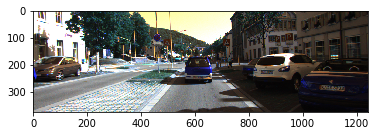

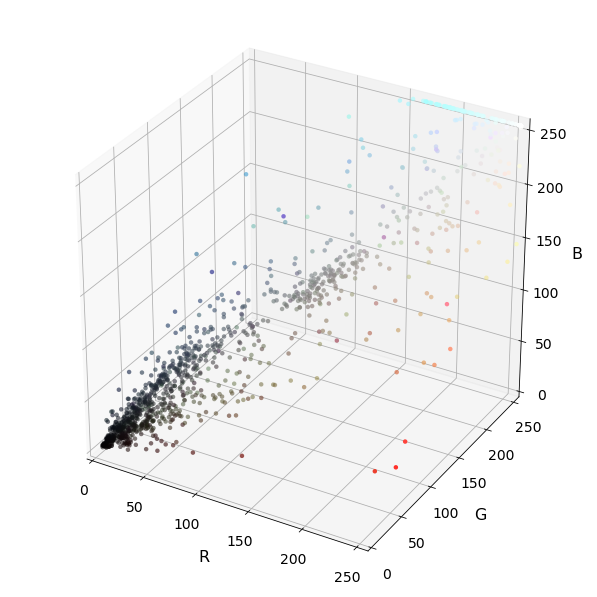

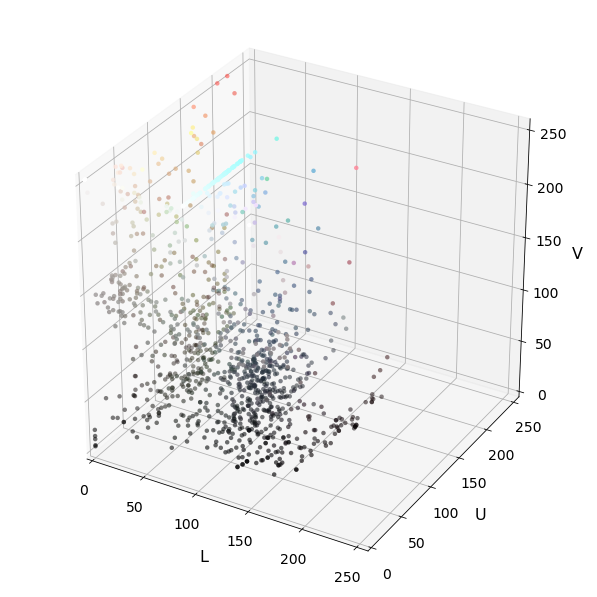

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
testing_img = cv2.imread('awesome.png')
plt.imshow(testing_img)

# Select a small fraction of pixels to plot by subsampling it
scale = max(testing_img.shape[0], testing_img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(testing_img, (np.int(testing_img.shape[1] / scale), np.int(testing_img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

In [2]:
# very high amounts of separation of ALL colours of cars in the V dimension of YUV colour space _HSV too!

## 1. Library Imports

In [3]:
# import all relevant libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import glob
from skimage.feature import hog
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque

%matplotlib inline

## 2a. Data Allocation

In [4]:
# array for vehicles and nonvehicles

vehicles = []
notvehicles = []
vehicles = glob.glob('training_dataset/vehicles/**/*.png')
notvehicles = glob.glob('training_dataset/non-vehicles/**/*.png')
print((vehicles[34]))


training_dataset/vehicles\GTI_Far\image0047.png


## 2b. Testing Data Allocation

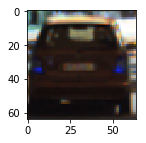

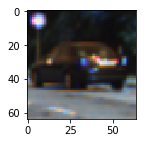

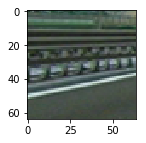

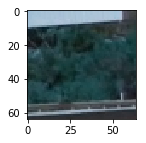

In [5]:
# read in an example image utilizing a 'for' loop

img = cv2.imread('training_dataset/vehicles/vehicles/GTI_Far/image0012.png')

for i in range(2):
    img = cv2.imread(vehicles[np.random.randint(0,len(vehicles))])
    plt.figure(figsize=(2,2))
    plt.imshow(img)

#non-vehicles
    
for i in range(2):
    img = cv2.imread(notvehicles[np.random.randint(0,len(notvehicles))])
    plt.figure(figsize=(2,2))
    plt.imshow(img)

## 3a. Define Hog Feature Extraction Fuction & Test (Part 1)

In [6]:
#from lesson, potential changes are below.


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec= False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

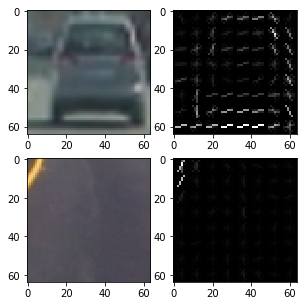

In [7]:
# apply HOG to vehicle example and non-vehicle example at random

vehicle = mpimg.imread(vehicles[7])

features_vehicle, hog_vehicle = get_hog_features(vehicle[:,:,2],9,8,2, vis=True, feature_vec=True)

notvehicle = mpimg.imread(notvehicles[11])
features_notvehicle, hog_notvehicle = get_hog_features(notvehicle[:,:,2],9,8,2, vis=True, feature_vec=True)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5,5))
f.subplots_adjust(hspace = .2, wspace=.1)
ax1.imshow(vehicle)
ax2.imshow(hog_vehicle, cmap ='gray')
ax3.imshow(notvehicle)
ax4.imshow(hog_notvehicle, cmap ='gray')

## 3b. Define Hog Feature Extraction Fuction (Part 2)

In [8]:
# the following fuction extracts features from a list of images_taken from lesson
# bin_spatial() and color_hist() get called via the extract_features functions

# change defining variables to below: 
# def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                        hist_bins=32, hist_range=(0, 256)):





def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Apply bin_spatial() to get spatial color features taking into account both options for hist, spatial & hog
                
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


## 3c. Apply Hog Feature Extraction to ALL Images

In [9]:
# extract the hog features from all images! We can now apply the fuction
# and utilize it on all of our images, and then train our model!

cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = "ALL" 
spatial_size = (32,32)
hist_bins = 32    
spatial_feat = True
hist_feat = True 
hog_feat = True 

# The following hyperparameters were seen in the lesson performing well, as well as tested
# and found to be the best results

t=time.time()

vehicle_features = extract_features(vehicles, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notvehicle_features = extract_features(notvehicles, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((vehicle_features, notvehicle_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(notvehicle_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

245.97 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## 4. Support Vector Machine (SVC) Classifier Training

In [10]:
# train the SVC

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
#n_predict = 10

64.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9921


## 5. Apply SVC for Vehicle Detection & Test

In [11]:
# Taken from lesson

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSL':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def find_vehicles(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return draw_img, bboxes



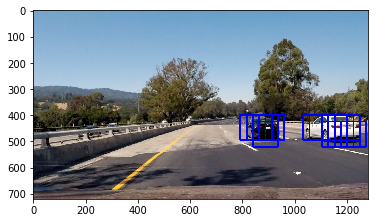

In [12]:
# Some prelimintary testing is warranted and performed below

test_img = mpimg.imread('test_images/test4.jpg')

# numbers taken from the lesson

ystart = 400
ystop = 656
scale = 1.5
#colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9
#pix_per_cell = 8
#cell_per_block = 2
#hog_channel = 'ALL' #Can be 0, 1, 2, or "ALL"
#spatial_size =(32,32)
#hist_bins = 32

out_img, bboxes = find_vehicles(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

## 6. Sliding Window Fuction (Hog Sub-sampling Window Search & Test) 

In [13]:
# Wow, the above is able to perform reasonably well! 

# the function below fits the sliding window search from the lesson 
# the numbers were tested and changed a few times before commiting to the current values
# once the results were deemed acceptable
# several iterations were performed to minimize false positives

def sliding_window(img,svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    # YUV seemed to be the most promising from the lesson
    orient = 9
    #perhaps try a higher orient & retrain_both vector lengths must have
    #the same length otherwise there would be an error in the "image show" cell after this one
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    # ystart_400, ystop_656, scale_1.5_starting points, find a better alternative set of hyperparemeters
    # possible change the set-up below into a loop like in the lesson
    
    bboxes = []
    
    #number = 1
    #while number <= 10:
        ##INSERT ALGORITHM
        #ystart = 400
        #ystop = 500
        #scale = 1.0
        #output_img, bboxes_output1 = find_vehicles(img, ystart, ystop,
                           #scale, svc, X_scaler, orient,
                           #pix_per_cell, cell_per_block, 
                           #spatial_size, hist_bins)
        #bboxes.extend(bboxes_output1)
    
        #ystart = ystart + 10
        #ystop = ystop + 15
        #scale = scale + 0.2
        #PERHAPS USE A BETTER SCALING FACTOR WITH EQUATIONS TO MATCH THE PREVIOUS NUMBERS
        
        #now, either find a way to do this to the string 'bboxes_output1 = bboxes_output(1+1)', or
        #set them all up to be from bboxes_output1 and rename variables accordingly later on
        
        #number = number + 1 
        
        # DICTIONARY is the best way to do this!, but since I only need a few I've found, I would
        
    
    ystart = 400
    ystop = 512
    scale = 1.05
    output_img, bboxes_output1 = find_vehicles(img, ystart, ystop,
                           scale, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
    bboxes.extend(bboxes_output1)
    
    ystart = 400
    ystop = 516
    scale = 1.3
    output_img, bboxes_output2 = find_vehicles(img, ystart, ystop,
                           scale, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
    bboxes.extend(bboxes_output2)
    
    
    ystart = 420
    ystop = 516
    scale = 1.5
    output_img, bboxes_output3 = find_vehicles(output_img, ystart, ystop,
                           scale, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
    bboxes.extend(bboxes_output3)
    
    
    return output_img, bboxes

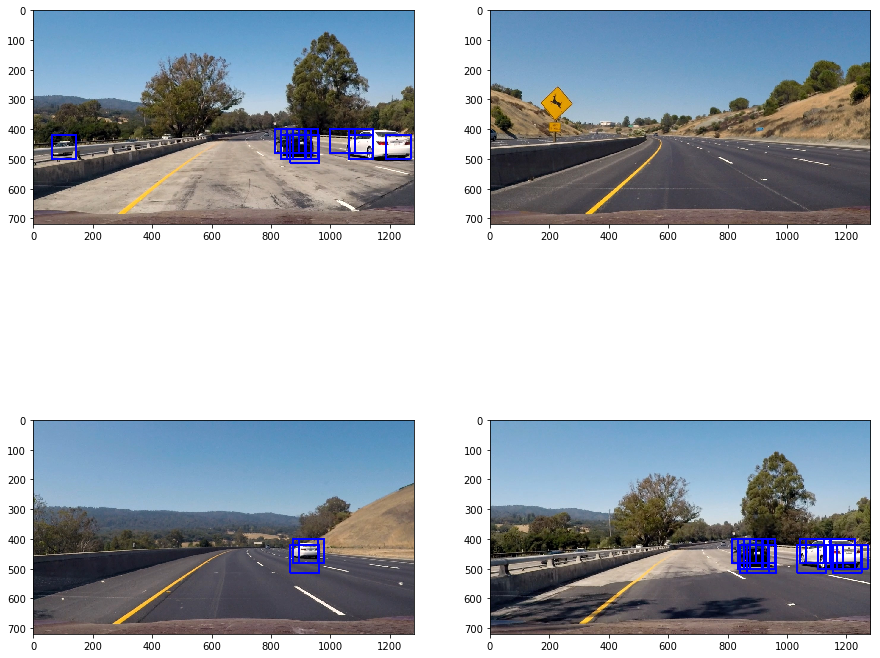

In [20]:
# Before spending at least an hour writing the video, it would be worthwhile to 
# test this on a few images with good results!! Hopefully no false positives

test_img_sliding1 = mpimg.imread('test_images/test1.jpg')
test_img_sliding2 = mpimg.imread('test_images/test2.jpg')
test_img_sliding3 = mpimg.imread('test_images/test3.jpg')
test_img_sliding4 = mpimg.imread('test_images/test4.jpg')

output_sliding_img1, bboxes1 = sliding_window(test_img_sliding1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_sliding_img2, bboxes2 = sliding_window(test_img_sliding2, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_sliding_img3, bboxes3 = sliding_window(test_img_sliding3, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_sliding_img4, bboxes4 = sliding_window(test_img_sliding4, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#plt.imshow(output_sliding_img1)
# ect
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
f.subplots_adjust(hspace = .01, wspace=.2)
ax1.imshow(output_sliding_img1)
ax2.imshow(output_sliding_img2)
ax3.imshow(output_sliding_img3)
ax4.imshow(output_sliding_img4)

## 7. Heatmap (for false positive reduction) & Test

In [21]:
# utilize a heatmap to take many boxes over the car and turn them into a single one
# to make further algorithms less confusing
# this was taken from the lesson

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

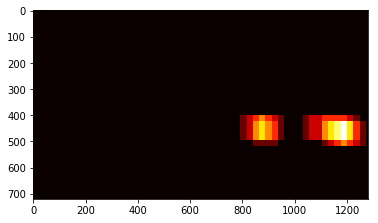

In [22]:
# test the heat map on an image

heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, bboxes)
plt.imshow(heatmap_img, cmap='hot')

In [23]:
# to further reduce false positives, a threshold is applied to reject rectangle 
# numbers that fall below the number that is it set to

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


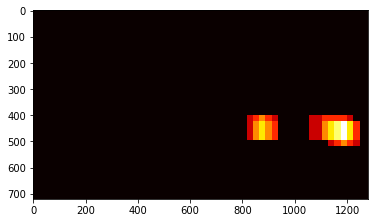

In [24]:
# test on an image

threshold_img = apply_threshold(heatmap_img,1)
plt.imshow(threshold_img, cmap='hot')

2 vehicles found


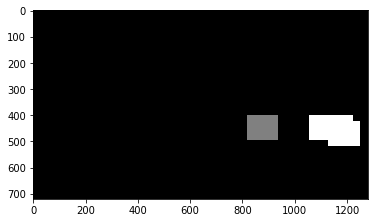

In [25]:
# apply threshold on an image

labels = label(heatmap_img)

gray_threshold = apply_threshold(heatmap_img, 2)
#labels = label(heatmap_img)
print(labels[1], 'vehicles found')
plt.imshow(labels[0], cmap='gray')

# reduce the number above to reduce the number of false positives

In [26]:
# transfer the heatmap back into a single rectangle box

def draw_labeled_bboxes(img, labels):
    
    for vehicle_number in range(1, labels[1]+1):
        
        nonzero = (labels[0] == vehicle_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


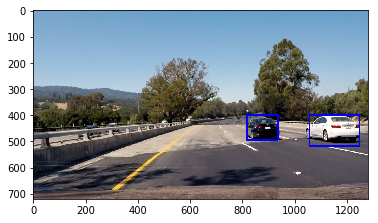

In [27]:
# test on an image

draw_bbox_img  = draw_labeled_bboxes(test_img, labels)
plt.imshow(draw_bbox_img)

## 8. Define Tracking Pipeline 

In [28]:
# video pipeline

d_history = deque(maxlen = 8)
def tracking_pipeline(img):
    bboxes = []
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 512
    scale = 1.05
    output_img, bboxes_output1 = find_vehicles(img, ystart, ystop,
                           scale, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
    bboxes.extend(bboxes_output1)
    
    ystart = 400
    ystop = 516
    scale = 1.3
    output_img, bboxes_output2 = find_vehicles(img, ystart, ystop,
                           scale, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
    bboxes.extend(bboxes_output2)
    
    
    ystart = 420
    ystop = 516
    scale = 1.5
    output_img, bboxes_output3 = find_vehicles(output_img, ystart, ystop,
                           scale, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
    bboxes.extend(bboxes_output3)

                  
    heatmap_img = np.zeros_like(output_img[:,:,0]).astype(np.float)
    
    heatmap_img_add = add_heat(heatmap_img, bboxes)
    
    threshold_img = apply_threshold(heatmap_img_add,1)
    
    current_heatmap = np.clip(threshold_img, 0, 255)
    d_history.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    
    for heat in d_history:
        heatmap = heatmap + heat
        
    labels = label(heatmap)
    
    draw_bbox_img  = draw_labeled_bboxes(img, labels)
    
    return draw_bbox_img

## 9. Video Outputs (Test & Project Video)

In [29]:
# before writing on the large project video, try on small

test_video_output = 'test_video_output5_redoa.mp4'
clip = VideoFileClip('test_video.mp4')
clip_out = clip.fl_image(tracking_pipeline)
%time clip_out.write_videofile(test_video_output, audio=False)



[MoviePy] >>>> Building video test_video_output5_redoa.mp4
[MoviePy] Writing video test_video_output5_redoa.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:44<00:01,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output5_redoa.mp4 

Wall time: 45.5 s


In [30]:
# final project video output

project_video_output = 'project_video_output_project5_redob_YUV.mp4'

clip2 = VideoFileClip('project_video.mp4')
clip_out2 = clip2.fl_image(tracking_pipeline)
%time clip_out2.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output_project5_redob_YUV.mp4
[MoviePy] Writing video project_video_output_project5_redob_YUV.mp4


100%|█████████████████████████████████████▉| 1260/1261 [32:37<00:02,  2.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_project5_redob_YUV.mp4 

Wall time: 32min 40s
